In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)




import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_v3 as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import sys
import matplotlib as mpl

# Clear matplotlib from sys.modules
for module in list(sys.modules.keys()):
    if module.startswith("matplotlib"):
        del sys.modules[module]

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
%config InlineBackend.figure_format = 'retina'
obj = lib.Fisher(fmin = 10, fmax = 2000, n_freq = 4000.)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [63]:
full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))



data_150914 = np.array(data[1])
data_150914[0] = 3
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390/10

idx = '150914'
if idx=='150914':
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))


epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = 0.4
x['s1_x'] = 0.02

hgr = obj.get_h_gr(x)
dhgr = obj.get_dh_gr(x)
paramgr = obj.paramdiffgr.copy()
paramgr_latex = obj.paramdiffgr_latex.copy()
freqs = obj.freqs.copy()

In [64]:

kinj = 3
norm = np.abs(lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)) 
dphik = 0.3/norm
dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)


Dh = {}
for d in ["H1", "L1", "V1"]:
    Dh[d] = 1j * dpsi_inj * hgr[d]

fi = obj.compute_joint_fish(x, paramgr, k = None)
bias_ip = obj.compute_biasip(x, Dh, paramgr, k = None)

idx_par = obj.idx_par.copy()
log_flag = obj.log_flag.copy()

In [65]:
cov = jnp.linalg.inv(fi)
dx_bias = np.array(cov @ bias_ip)
dx_stat = np.diagonal(np.array(cov ))**(1/2)
xvals = np.array([x[k] for k in paramgr])

dhpara = np.zeros_like(freqs)
for p in paramgr:
    if log_flag[p]:
        i = idx_par[p]
        dx_bias[i] = dx_bias[i]*x[p]
        dx_stat[i] = dx_stat[i]*x[p]

        dhpara = dhpara + dx_bias[i]*dhgr["H1"][p]

In [66]:
import pandas as pd

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args, titles=cycle([''])):
    html_str = ""
    for df, title in zip(args, chain(titles, cycle(['']))):
        html_str += f'<div style="display: inline-block; vertical-align: top; padding-right: 20px;">'
        html_str += f'<h3 style="text-align: center;">{title}</h3>'
        html_str += df.to_html(escape=False)  # Use escape=False to allow LaTeX rendering
        html_str += '</div>'
    display_html(html_str, raw=True)

xvaltrue = np.append(xvals,[dphik])
paramxtrue_latex = paramgr_latex + [rf"$\delta\varphi_{ kinj }$"]
df1 = pd.DataFrame(xvaltrue,paramxtrue_latex, [r"$\Theta_\mathrm{t}$"]).round(3)
df2 = pd.DataFrame(dx_bias, paramgr_latex, columns=[r"$\Delta\Theta_\mathrm{bias}$"]).round(3)
df3 = pd.DataFrame(dx_stat, paramgr_latex, [r"$\Delta\Theta_\mathrm{stat}$"]).round(3)

snr_latex = [r"$\rho_H$","$\rho_L$","$\rho_V$","$\rho_N$"]
snrarr = np.real(np.array(list(obj.get_snrs_gr(x).values())))
df4 = pd.DataFrame(snrarr,snr_latex, [r"$\rho$"]).round(1)
display_side_by_side(df1,df2, df3, df4)
# display_side_by_side(df1,df2, df3)

,$\Theta_\mathrm{t}$
$M_c$,3.000
$\eta$,0.247
$d_L$,39.000
$\text{ra}$,1.856
$\text{dec}$,-0.073
$\iota$,1.053
$\psi$,0.980
$t_c$,0.000
$\phi_c$,0.000
$s_{1x}$,0.400


In [67]:
def get_stuff(kinj):
    norm = lib.get_dpsi_ppe(10, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
    dphik = 1/norm
    dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    
    Dh = {}
    for d in ["H1", "L1", "V1"]:
        Dh[d] = 1j * dpsi_inj * hgr[d]
    
    fi = obj.compute_joint_fish(x, paramgr, k = None)
    bias_ip = obj.compute_biasip(x, Dh, paramgr, k = None)
    
    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()
    
    cov = jnp.linalg.inv(fi)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)
    xvals = np.array([x[k] for k in paramgr])
    
    dhpara = np.zeros_like(freqs)
    for p in paramgr:
        if log_flag[p]:
            i = idx_par[p]
            dx_bias[i] = dx_bias[i]*x[p]
            dx_stat[i] = dx_stat[i]*x[p]
    
            dhpara = dhpara + dx_bias[i]*dhgr["H1"][p]
    dh_perp = Dh["H1"] - dhpara
    dpsi_perp = np.array((dh_perp)/1j/hgr["H1"])
    res = {'freqs' : freqs, 'dpsi_inj' : dpsi_inj, 'dpsi_perp' : dpsi_perp, 'dh' : Dh["H1"], 'h' : hgr["H1"], 'dh_perp' : dh_perp}
    return res

res = get_stuff(3)

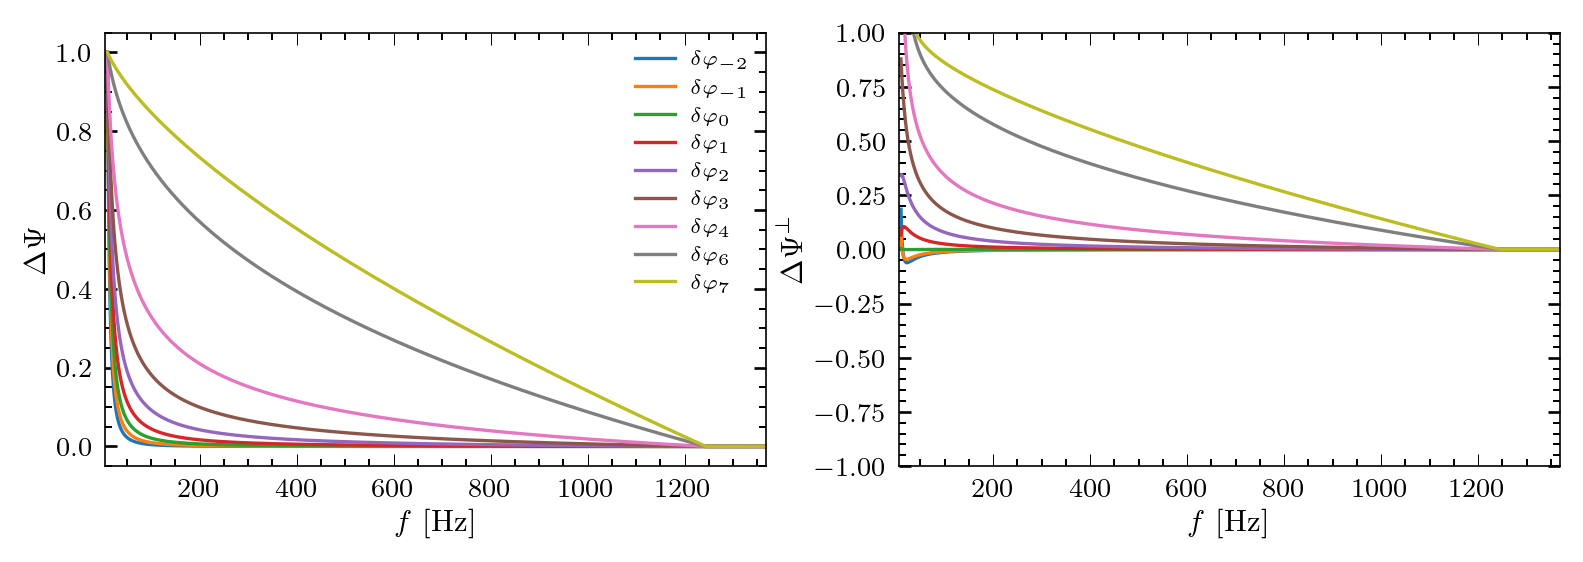

In [68]:

default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(default_figsize[0] * 510/246, default_figsize[1]))


for kinj in [-2, -1, 0, 1, 2, 3, 4, 6, 7]:
    res = get_stuff(kinj)
    freqs = res['freqs']
    dpsi_inj = res['dpsi_inj']
    dpsi_perp = res['dpsi_perp']
    i = np.argmin((freqs - obj.fend) ** 2)
    
    line, = axes[0].plot(freqs, dpsi_inj, label=rf"$\delta\varphi_{{ {kinj} }}$")
    axes[1].plot(freqs, np.real(dpsi_perp ), c=line.get_color())

axes[0].set_xlim(5, obj.fend * 1.1)
axes[1].set_ylim(-1, 1)
axes[0].set_xlabel("$f$ [Hz]")
axes[0].set_ylabel("$\Delta\Psi$")
axes[0].legend(loc=0)


axes[1].set_xlim(5, obj.fend * 1.1)
axes[1].set_ylim(-1, 1)
axes[1].set_xlabel("$f$ [Hz]")
axes[1].set_ylabel("$\Delta\Psi^\perp$")
# fig.suptitle("$M_c = 3$")
# plt.savefig(datestr + "-dephasing-PN-150914.pdf", bbox_inches='tight', pad_inches=0)
plt.show()



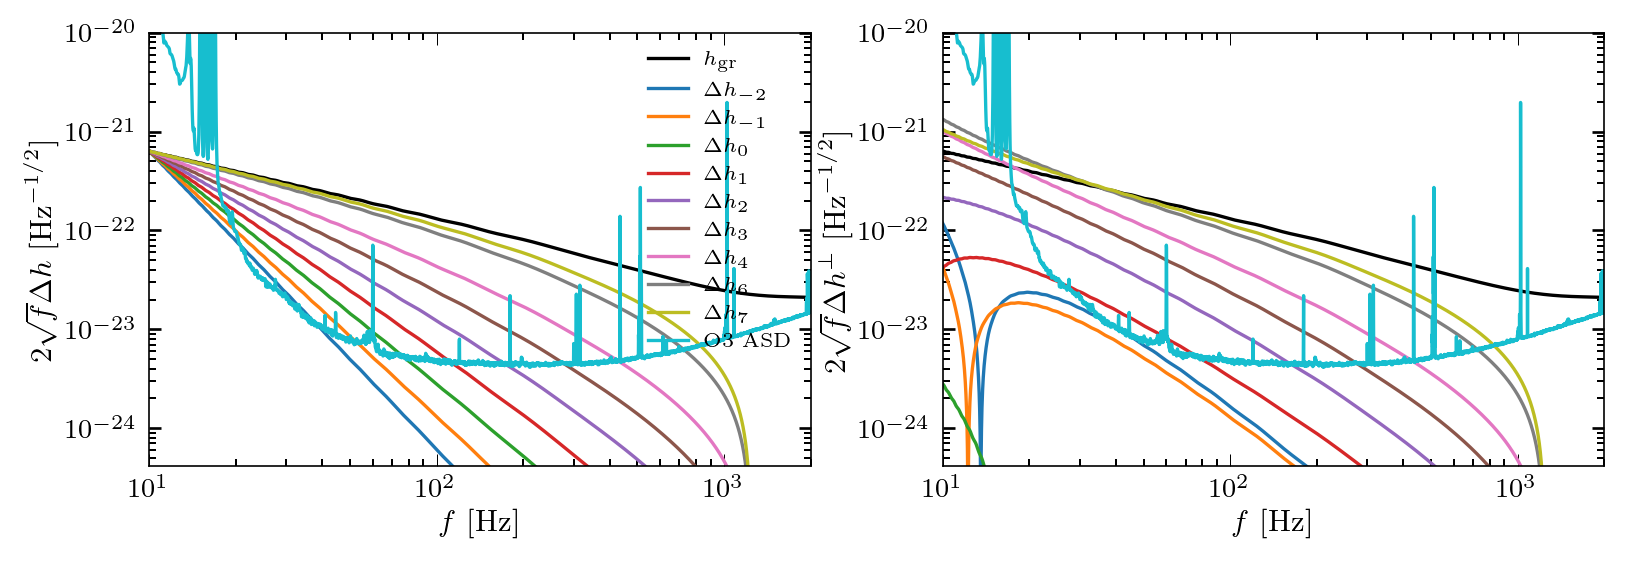

In [70]:
res = get_stuff(3)
freqs = res['freqs']
h = res['h']
asd = obj.psdO3**(1/2)
# plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(h))

default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(default_figsize[0] * 510/246, default_figsize[1]))

line, = axes[0].loglog(freqs, 2*np.sqrt(freqs)*np.abs(h), label=r"$h_\mathrm{gr}$", c = "k")
axes[1].loglog(freqs, 2*np.sqrt(freqs)*np.abs(h), c=line.get_color())



for kinj in [-2, -1, 0, 1, 2, 3, 4, 6, 7]:
    res = get_stuff(kinj)
    freqs = res['freqs']
    dh = res['dh']
    dh_perp = res['dh_perp']
    
    
    # line, = axes[0].plot(freqs, dpsi_inj - dpsi_inj[i], label=rf"$\delta\varphi_{{ {kinj} }}$")
    # axes[1].plot(freqs, np.real(dpsi_perp - dpsi_perp[i]), c=line.get_color())
    line, = axes[0].plot(freqs, 2*np.sqrt(freqs)*np.abs(dh), label=rf"$\Delta h_{{ {kinj} }}$")
    axes[1].plot(freqs, 2*np.sqrt(freqs)*np.abs(dh_perp), c=line.get_color())

line, = axes[0].plot(freqs, asd, label=r"O3 ASD")
axes[1].plot(freqs, asd, c=line.get_color())

axes[0].legend(loc=0)
axes[0].set_xlim(10, 2000)
axes[0].set_ylim(np.min(asd)/1e1, 1e-20)
axes[0].set_xlabel("$f$ [Hz]")
axes[0].set_ylabel("$2\sqrt{f}  \Delta h$  [Hz$^{-1/2}$]")
axes[0].legend(loc=0)

axes[1].set_xlim(10, 2000)
axes[1].set_ylim(np.min(asd)/1e1, 1e-20)
axes[1].set_xlabel("$f$ [Hz]")
axes[1].set_ylabel("$2\sqrt{f} \Delta h^\perp$  [Hz$^{-1/2}$]")
# fig.suptitle("$M_c = 3$")
# plt.savefig(datestr + "-amplitude-PN-150914.pdf", bbox_inches='tight', pad_inches=0)
plt.show()